In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


In [27]:
# Load your training and testing datasets
train_df = pd.read_csv('/content/drive/MyDrive/dataset/btc_usdt_2023_binance.csv')
test_df = pd.read_csv('/content/drive/MyDrive/dataset/unseen.csv')

# Extract the relevant features
train_data = train_df[['open', 'high', 'low', 'close', 'volume']].values
# test_data = test_df[['close']].values
test_data = test_df[['open', 'high', 'low', 'close', 'volume']].values

# Normalize the data using the scaler fitted on the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

# Define the sequence length (number of time steps to consider)
sequence_length = 10  # You may adjust this based on your dataset

# Create sequences and labels for training set
train_sequences, train_labels = [], []
for i in range(len(scaled_train_data) - sequence_length):
    seq = scaled_train_data[i:i+sequence_length]
    label = scaled_train_data[i+sequence_length, 3]  # Assuming you want to predict the 'close' price
    train_sequences.append(seq)
    train_labels.append(label)

# Convert lists to numpy arrays
X_train = np.array(train_sequences)
y_train = np.array(train_labels)

# Create sequences and labels for testing set
test_sequences, test_labels = [], []
for i in range(len(scaled_test_data) - sequence_length):
    seq = scaled_test_data[i:i+sequence_length]
    label = scaled_test_data[i+sequence_length, 3]  # Assuming you want to predict the 'close' price
    test_sequences.append(seq)
    test_labels.append(label)

# Convert lists to numpy arrays
X_test = np.array(test_sequences)
y_test = np.array(test_labels)


In [ ]:
print()

In [8]:
# The sequences and labels are already created in the previous step

# Split the training data
split_percentage = 0.8
split_index = int(split_percentage * len(X_train))

X_train_split, X_val = X_train[:split_index], X_train[split_index:]
y_train_split, y_val = y_train[:split_index], y_train[split_index:]


In [9]:
from keras.callbacks import ModelCheckpoint

# Define the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_split.shape[1], X_train_split.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Define the ModelCheckpoint callback to save the entire model
checkpoint_filepath = '/content/drive/MyDrive/models/chatgpt_checkpoint.h5'
model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Train the model with the callback
history = model.fit(
    X_train_split, y_train_split,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[model_checkpoint]
)


Epoch 1/50
2515/2520 [============================>.] - ETA: 0s - loss: 2.8812e-04
Epoch 1: val_loss improved from inf to 0.00106, saving model to /content/drive/MyDrive/models/chatgpt_checkpoint.h5
2520/2520 [==============================] - 27s 9ms/step - loss: 2.8759e-04 - val_loss: 0.0011
Epoch 2/50
  17/2520 [..............................] - ETA: 17s - loss: 1.1701e-05

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2516/2520 [============================>.] - ETA: 0s - loss: 1.4382e-05
Epoch 2: val_loss improved from 0.00106 to 0.00071, saving model to /content/drive/MyDrive/models/chatgpt_checkpoint.h5
2520/2520 [==============================] - 21s 8ms/step - loss: 1.4377e-05 - val_loss: 7.1431e-04
Epoch 3/50
2517/2520 [============================>.] - ETA: 0s - loss: 1.3134e-05
Epoch 3: val_loss improved from 0.00071 to 0.00029, saving model to /content/drive/MyDrive/models/chatgpt_checkpoint.h5
2520/2520 [==============================] - 24s 9ms/step - loss: 1.3124e-05 - val_loss: 2.9472e-04
Epoch 4/50
2518/2520 [============================>.] - ETA: 0s - loss: 1.2568e-05
Epoch 4: val_loss did not improve from 0.00029
2520/2520 [==============================] - 22s 9ms/step - loss: 1.2563e-05 - val_loss: 5.5680e-04
Epoch 5/50
2516/2520 [============================>.] - ETA: 0s - loss: 9.7636e-06
Epoch 5: val_loss did not improve from 0.00029
2520/2520 [==============================] - 

In [ ]:
from keras.models import load_model

# Load the entire model
model = load_model(checkpoint_filepath)


9/9 [==============================] - 0s 3ms/step
Mean Squared Error: 24413656790887.74


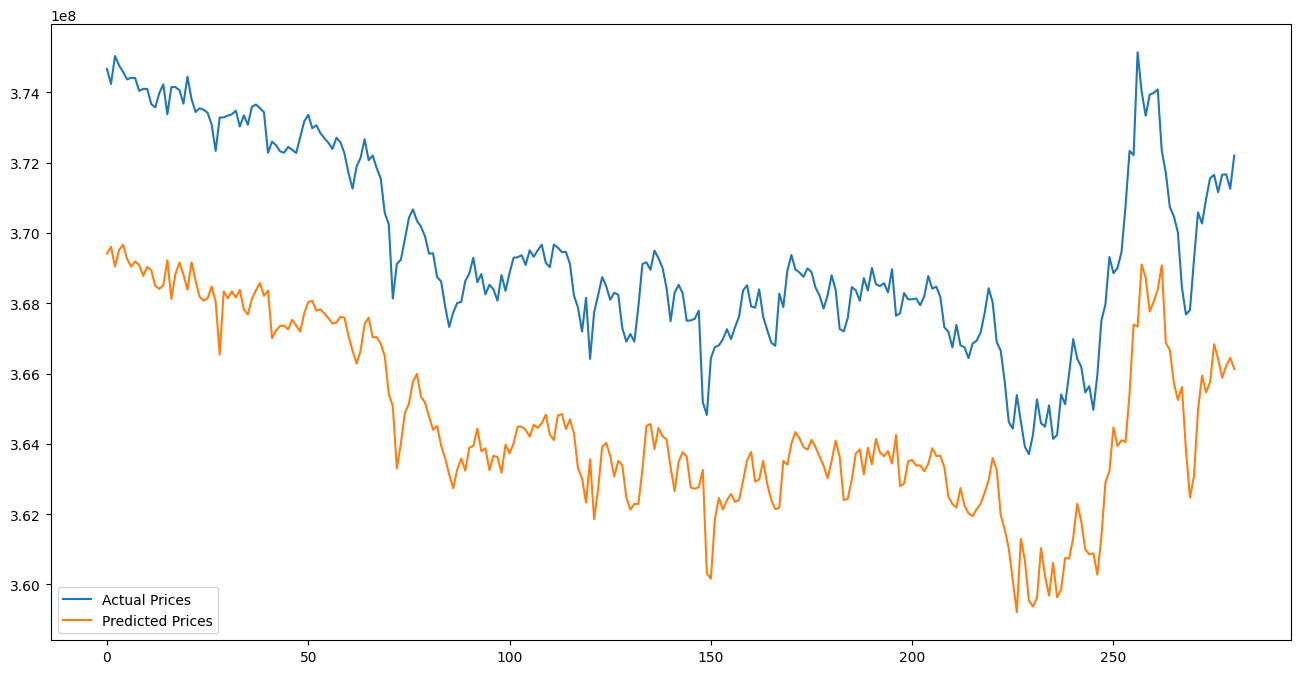

In [56]:
# Make predictions
predicted_values = model.predict(X_test)

# Reshape predicted_values to match the shape of X_test
predicted_values_reshaped = predicted_values.reshape(-1, 1)

# Inverse transform the predictions and actual values
X_test_reshaped = X_test[:, :, :4].reshape(-1, 4)  # Ensure 2D shape for X_test

# Make sure both arrays have the same number of rows before concatenation
min_rows = min(X_test_reshaped.shape[0], predicted_values_reshaped.shape[0])
X_test_reshaped = X_test_reshaped[:min_rows]
predicted_values_reshaped = predicted_values_reshaped[:min_rows]

predicted_values = scaler.inverse_transform(np.concatenate((X_test_reshaped, predicted_values_reshaped), axis=1))[:, -1]
actual_values = scaler.inverse_transform(np.concatenate((X_test_reshaped, y_test.reshape(-1, 1)[:min_rows]), axis=1))[:, -1]

# Calculate Mean Squared Error
mse = mean_squared_error(actual_values, predicted_values)
print(f'Mean Squared Error: {mse}')

# Visualize the results
plt.figure(figsize=(16, 8))
plt.plot(actual_values, label='Actual Prices')
plt.plot(predicted_values, label='Predicted Prices')
plt.legend()
plt.show()


In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import load_model, Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import yfinance as yf

# Load the saved model
saved_model_path = '/content/drive/MyDrive/models/chatgpt_checkpoint.h5'
model = load_model(saved_model_path)

# Fetch last 24 hours of Bitcoin prices with 5-minute interval using yfinance
symbol = 'BTC-USD'
btc_data = yf.download(symbol, period='1d', interval='5m')
btc_data.index = btc_data.index.tz_convert('Asia/Karachi')
new_data = btc_data[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Normalize the new data using the scaler fitted on the training data
scaled_new_data = scaler.transform(new_data)


[*********************100%%**********************]  1 of 1 completed


In [109]:
# Create sequences and labels for the new data
new_sequences, new_labels = [], []
for i in range(len(scaled_new_data) - sequence_length):
    seq = scaled_new_data[i:i+sequence_length]
    label = scaled_new_data[i+sequence_length, 3]  # Assuming 'close' price
    new_sequences.append(seq)
    new_labels.append(label)

# Convert lists to numpy arrays
X_new = np.array(new_sequences)
y_new = np.array(new_labels)
# Update the training data with the new data
X_train_updated = np.concatenate((X_train, X_new), axis=0)
y_train_updated = np.concatenate((y_train, y_new), axis=0)
# Retrain the model with the updated data
early_stopping = EarlyStopping(
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    monitor='val_loss',
    mode='min',
    verbose=1
)
history = model.fit(
    X_train_updated, y_train_updated,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[model_checkpoint, early_stopping]
)


Epoch 1/50
3153/3159 [============================>.] - ETA: 0s - loss: 1.2592e-05
Epoch 1: val_loss did not improve from 0.00000
3159/3159 [==============================] - 31s 9ms/step - loss: 1.2595e-05 - val_loss: 9.4471e-06
Epoch 2/50
3155/3159 [============================>.] - ETA: 0s - loss: 1.2477e-05
Epoch 2: val_loss did not improve from 0.00000
3159/3159 [==============================] - 26s 8ms/step - loss: 1.2468e-05 - val_loss: 3.8923e-06
Epoch 3/50
3153/3159 [============================>.] - ETA: 0s - loss: 1.2518e-05
Epoch 3: val_loss did not improve from 0.00000
3159/3159 [==============================] - 26s 8ms/step - loss: 1.2503e-05 - val_loss: 4.1908e-06
Epoch 4/50
3157/3159 [============================>.] - ETA: 0s - loss: 1.2361e-05
Epoch 4: val_loss did not improve from 0.00000
3159/3159 [==============================] - 26s 8ms/step - loss: 1.2358e-05 - val_loss: 4.7660e-06
Epoch 5/50
3152/3159 [============================>.] - ETA: 0s - loss: 1.2238e-

In [110]:
model.save('/content/drive/MyDrive/models/updated_chatgpt_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



9/9 [==============================] - 1s 3ms/step


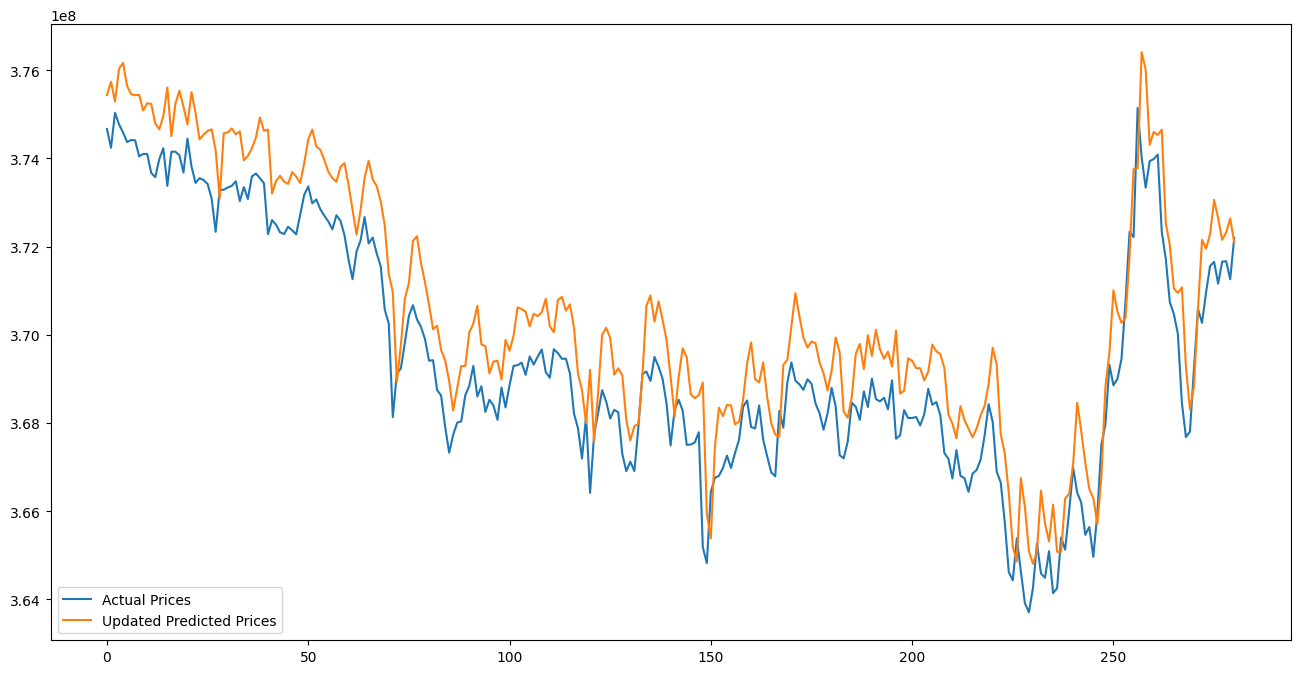

In [111]:
# Make predictions using the updated model
predicted_values_updated = model.predict(X_test)

# Reshape and inverse transform the predictions and actual values
predicted_values_reshaped_updated = predicted_values_updated.reshape(-1, 1)
# Ensure both arrays have the same number of rows before concatenation
min_rows = min(X_test_reshaped.shape[0], predicted_values_reshaped_updated.shape[0])

# Extract relevant portions and concatenate
concatenated_data = np.concatenate((
    X_test_reshaped[:min_rows, :],
    predicted_values_reshaped_updated[:min_rows, :]
), axis=1)

# Inverse transform the concatenated values
predicted_values_updated = scaler.inverse_transform(concatenated_data)[:, -1]
# Visualize the updated results
plt.figure(figsize=(16, 8))
plt.plot(actual_values, label='Actual Prices')
plt.plot(predicted_values_updated, label='Updated Predicted Prices')
plt.legend()
plt.show()


In [113]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import yfinance as yf
import datetime

# Load the saved model
saved_model_path = '/content/drive/MyDrive/models/updated_chatgpt_model.h5'
model = load_model(saved_model_path)

# Fetch the latest Bitcoin prices
symbol = 'BTC-USD'
latest_data = yf.download(symbol, period='1d', interval='5m')
latest_data.index = latest_data.index.tz_convert('Asia/Karachi')

# Extract relevant features
latest_features = latest_data[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Normalize the latest data using the scaler fitted on the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_latest_data = scaler.fit_transform(latest_features)

# Create sequences for the latest data
latest_sequences = []
for i in range(len(scaled_latest_data) - sequence_length):
    seq = scaled_latest_data[i:i + sequence_length]
    latest_sequences.append(seq)

# Convert list to numpy array
X_latest = np.array(latest_sequences)

# Make predictions using the model
predicted_values_latest = model.predict(X_latest)

# Reshape and inverse transform the predictions
predicted_values_reshaped_latest = predicted_values_latest.reshape(-1, 1)
min_rows = min(scaled_latest_data[:, :4].reshape(-1, 4).shape[0], predicted_values_reshaped_latest.shape[0])

# Extract relevant portions and concatenate
concatenated_data = np.concatenate((
    scaled_latest_data[:, :4].reshape(-1, 4)[:min_rows, :],
    predicted_values_reshaped_latest[:min_rows, :]
), axis=1)

# Inverse transform the concatenated values
predicted_values_latest = scaler.inverse_transform(concatenated_data)[:, -1]

# Generate timestamps for the next 24 hours with 5-minute intervals
latest_timestamp = latest_data.index[-1]
timestamps_future = pd.date_range(latest_timestamp, periods=len(predicted_values_latest) + 1, freq='5T')[1:]

# Create a DataFrame with timestamps and predicted values
predicted_df_latest = pd.DataFrame({'Timestamp': timestamps_future, 'Predicted': predicted_values_latest})
predicted_df_latest.set_index('Timestamp', inplace=True)

# Display the predicted prices
print(predicted_df_latest)


[*********************100%%**********************]  1 of 1 completed
9/9 [==============================] - 1s 5ms/step
                              Predicted
Timestamp                              
2023-12-18 04:05:00+05:00  3.205551e+08
2023-12-18 04:10:00+05:00  3.168543e+08
2023-12-18 04:15:00+05:00  2.876699e+08
2023-12-18 04:20:00+05:00  2.932367e+08
2023-12-18 04:25:00+05:00  3.316137e+08
...                                 ...
2023-12-19 01:55:00+05:00  4.035234e+07
2023-12-19 02:00:00+05:00  4.452827e+07
2023-12-19 02:05:00+05:00  4.927164e+07
2023-12-19 02:10:00+05:00  1.051411e+08
2023-12-19 02:15:00+05:00  2.806837e+07

[267 rows x 1 columns]


In [131]:
import plotly.graph_objects as go

# Create a Plotly figure
fig = go.Figure()

# Plot latest actual prices
print(latest_data.Close[1])
fig.add_trace(go.Scatter(x=latest_data.index, y=latest_data.Close, mode='lines', name='Latest Actual Prices'))

# Plot predicted prices for the next 24 hours
fig.add_trace(go.Scatter(x=predicted_df_latest.index, y=predicted_df_latest['Predicted'], mode='lines', name='Predicted Prices'))

# Customize layout
fig.update_layout(title='Bitcoin Price Prediction - Latest Actual vs. Predicted Prices',
                  xaxis_title='Time',
                  yaxis_title='Bitcoin Price (USD)',
                  hovermode='x unified',
                  legend=dict(x=0, y=1))

# Show the interactive graph in Colab
fig.show()


42241.3203125
